In [7]:
import numpy as np
import pandas as pd
import math
import scipy.stats as ss
# From ss we use ss.kstest() for Komogorov Smirnov and ss.cramervonmises_2samp(x, y) for the two sample comparison using Cramer-von Mises
# The ss.bootstrap() function works great if you want to do a traditional bootstrap, where you draw from your sample of N data points 
# N random data points with replacement; however we aim to sub-sample. 
import statsmodels.api as sm # Import for autocorrelation estimate and plot using sm.graphics.tsa.plot_acf

# Plot imports and parameters 
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'Tahoma',
        'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

## Purpose
This notebook is for help with comparing distributions of data, with special attention to MD datasets. The Kolmogorov Smirnov (KS) test and Cramer-von Mises (CvM) tests are used. The KS test is non-parameteric, which makes it particularly useful for data where the underlying distribution is not known. 

### References
[1] Zeimbekakis, A., Schifano, E. D., & Yan, J. (2024). On Misuses of the Kolmogorov–Smirnov Test for One-Sample Goodness-of-Fit. The American Statistician, 78(4), 481-487.
https://www.tandfonline.com/doi/full/10.1080/00031305.2024.2356095 \
[2] Büning, H. (2002). Robustness and power of modified Lepage, Kolmogorov-Smirnov and Crame´ r-von Mises two-sample tests. Journal of Applied Statistics, 29(6), 907-924.
https://www.tandfonline.com/doi/abs/10.1080/02664760220136212

### Tutorials
1. How the KS test looks for differences between two distriubtions: \
https://towardsdatascience.com/understanding-kolmogorov-smirnov-ks-tests-for-data-drift-on-profiled-data-5c8317796f78/
2. Dealing with auto-correlated data (MD data often is): \
   https://engineering.atspotify.com/2023/09/how-to-accurately-test-significance-with-difference-in-difference-models
3. Potential pitfalls of the K-S test! \
   https://asaip.psu.edu/articles/beware-the-kolmogorov-smirnov-test/#:~:text=We%20recommend%20that%20the%20distribution%20of%20the,KS%20test%20in%20two%20or%20more%20dimensions.
5. Why Anderson Darling may be better, and a concise explanation of K-S's strengths and limitations: \
https://asaip.psu.edu/articles/beware-the-kolmogorov-smirnov-test/#:~:text=We%20recommend%20that%20the%20distribution%20of%20the,KS%20test%20in%20two%20or%20more%20dimensions.
6. Explaining reference [1]: \
https://www.reddit.com/r/statistics/comments/7j273q/still_dont_understand_why_the_pvalue_distribution/
7. Explaining uniform distribution of p-values: \
https://www.reddit.com/r/statistics/comments/7j273q/still_dont_understand_why_the_pvalue_distribution/ 

## Common pitfalls for the Kolmogorov-Smirnov test
* Data must be continuous [1] (consider if Chi-square Test if data is categorical)
    - Rounding continuous data can invalidate the test
    - "Ties", where two data points have the same value indicate that the underlying data generator does not create continuous data
* When comparing your distribution to another distribution (e.g. to see if your data is normal), your independent distribution should not be created using the mean and standard deviation of your dataset, but should be independent.
    - See tutorial explaining reference 1.
* Data should be independent (this is a major problem for MD data, which is usually from a time series and autocorrelated. autocorrelation means that the data at time x-i has some predicitive value for the data at time x, which for a protein moving in time is true -- as i goes to zero, the position at time x-i approaches the position at time x. Since the test assumes independence, autocorrelation contributes to an over-estimation of significance, along with the overpowering from excessive sampling) For more on methods to deal with this, see tutorial 2.

## Special considerations
* Consider using Anderson-Darling if the important differences between the distributions are in the tails. It may even be more advisable to always use A-D test. (https://asaip.psu.edu/articles/beware-the-kolmogorov-smirnov-test/#:~:text=We%20recommend%20that%20the%20distribution%20of%20the,KS%20test%20in%20two%20or%20more%20dimensions.)
* The CvM test also looks more holistically at the whole distribution, whereas the KS test looks only at the maximum difference in the cumulative distribution function (CDF).

# So what do we do. 

According to the blog post in tutorial [3], bootstrapping IS advisable. Nonetheless, there is mixed consensus on online forums, largely from the standpoint that it is entirely unclear what the sample size should be. There is consensus that confidence intervals are more important than using a p-value for hypothesis testing alone. At all times, it is important to keep in mind that statistics are more a way to characterize the data rather than to prove a claim. My recommendation is that when comparing distribution we focus less on a claim of "statistically significantly different" and more on claims like "For a 1,000 sample permutation bootstrap with sample size X, the 95% confidence interval for p-values was 0.06."

It is ambiguous if bootstrapping might be helpful in resolving the auto-correlation issue. My thought right now is maybe the raw data needs to be analyzed for an autocorrelateion period, and that the sample size should be based on sampling roughly one sample per period. Arguably, this would result in lots of instances where a sinlge period is sampled multiple times, so there would be auto-correlations still, but at the same time it's the only reason I can conjure to justify a given sample size. That said, there was not a clear fall off below 50% autocorrelation for my test data -- this may differ for a given dataset, and it is potentially worth examining the autocorrelation. 

Ultimately, the largest argument against bootstrapping seems to be that there's not a "correct" way to determine sample sizes. But, arguably, the whole sample size is not necessarily "correct" either; and on that note, the choice of test is not necessarily a matter of "correct-ness." The core idea is that we'd like to use statistics to convey to the reader the importance of the data. Doing a small parameter sweep on sample size may provide a more comprehensive description of the data. Ultimately, we will often fall bias to choosing to present the data using the plot we like the best, which is always a fundamental challenge, but one that we're perhaps more aware of by digging more deeply into the underlying statistics.  

There seems to be no reason to not use either A-D or Cramer-von Mises in place of K-S. The reason that C-M may be preferable is it normalizes across the whole distribution rather than relying on the maximum alone. Any of these can be reweighted in order to emphasize the underlying upper/lower distributions. 

It may be worthwhile to bootstrap on Z and look at distribution of P values. It should be linear, flat. And then to bootstrap for X and Y -- it should be non-linear.

In [8]:
# As an example, let's compare the distributions of groove width from WT and P210S data. 
# To mimic actual data better, we'll use all three replicates -- this adds to the challenge
# because replicates may sample different behavior, especially with intrinsically disordered regions

muts = ['WT','P210S']
reps = ['1','2','3']
combined_data = {'WT':[],'P210S':[]}
for mut in muts:
    temp = []
    for rep in reps:
        path = 'exampleData/'+mut+'_lig/MRPP2_'+rep+'_helices_distance.dat'
        df = pd.read_table(path, sep=r"\s+")
        temp.append(df.side1.values)
        temp.append(df.side2.values)
        # View autocorrelations based on individual replicates
        #sm.graphics.tsa.plot_acf(np.concatenate(np.array(temp))[0:-1:10], lags=30) # [0:-1:10] downsamples the data by 1/10th with the goal of reducing our sampling frequency to look at autocorrelation with more relevant times; this keeps the computation lighter
        #plt.axhline(.5, c = 'black')
        #plt.show()
        #plt.cla()
    
    temp = np.concatenate(np.array(temp))
    combined_data[mut] = temp
    # View autocorrelations based on all data for a given mutation
    #sm.graphics.tsa.plot_acf(temp[0:-1:10], lags=10) # [0:-1:10] downsamples the data by 1/10th with the goal of reducing our sampling frequency to look at autocorrelation with more relevant times; this keeps the computation lighter
    #plt.axhline(.5, c = 'black')
    #plt.show()
    #plt.cla()

(array([5.000e+00, 4.000e+00, 1.000e+01, 2.300e+01, 4.100e+01, 8.400e+01,
        1.720e+02, 2.320e+02, 3.330e+02, 5.350e+02, 7.200e+02, 9.960e+02,
        1.270e+03, 1.608e+03, 1.842e+03, 2.046e+03, 2.145e+03, 2.254e+03,
        2.097e+03, 1.869e+03, 1.676e+03, 1.386e+03, 1.154e+03, 9.890e+02,
        9.420e+02, 8.700e+02, 8.870e+02, 9.320e+02, 1.029e+03, 1.199e+03,
        1.480e+03, 1.765e+03, 2.229e+03, 2.634e+03, 2.959e+03, 3.444e+03,
        3.888e+03, 4.101e+03, 4.701e+03, 4.834e+03, 5.210e+03, 5.613e+03,
        6.069e+03, 6.468e+03, 6.808e+03, 7.312e+03, 7.793e+03, 8.361e+03,
        8.600e+03, 8.998e+03, 9.248e+03, 9.569e+03, 9.808e+03, 9.730e+03,
        9.656e+03, 9.745e+03, 9.592e+03, 9.386e+03, 9.072e+03, 8.876e+03,
        8.257e+03, 7.949e+03, 7.510e+03, 6.913e+03, 6.109e+03, 5.612e+03,
        4.854e+03, 4.267e+03, 3.718e+03, 3.060e+03, 2.651e+03, 2.142e+03,
        1.783e+03, 1.407e+03, 1.251e+03, 9.890e+02, 7.860e+02, 6.120e+02,
        5.650e+02, 4.400e+02, 3.400e+0

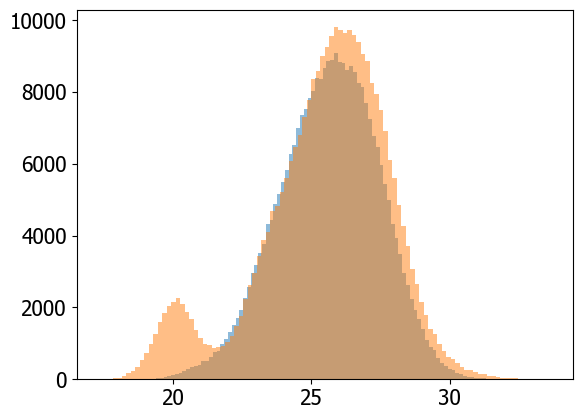

In [14]:
plt.hist(combined_data['WT'], bins = 100, alpha = .5)
plt.hist(combined_data['P210S'], bins = 100, alpha = .5)


In [9]:
# Run a permutation bootstrap; we did not use ss.bootstrap because it does not support subsampling -- subsampling is necessary because 1) my kernel crashes using
# the full data sample size andd 2) conceptually we are trying to unbiase our results from massive over sampling.
x = combined_data['WT']
y = combined_data['P210S']

from sklearn.utils import resample
n_resamples = 300 # number of times to randomly sub-sample
n = int(len(combined_data['P210S'])/1000) # sample size
cvm_pvals = [] # TODO: Wrap these up into a pre sized array and insert results on location to speed up
ks_pvals = []
cvm_stats = []
ks_stats = []
for i in np.arange(0,n_resamples):
    boot_x = resample(x, replace=True, n_samples=n)
    boot_y = resample(y, replace=True, n_samples=n)

    cvm_res = ss.cramervonmises_2samp(boot_x, boot_y)
    cvm_pvals.append(cvm_res.pvalue)
    cvm_stats.append(cvm_res.statistic)

    ks_res =  ss.kstest(x, y)
    ks_stats.append(ks_res[0])
    ks_pvals.append(ks_res[1])


KstestResult(statistic=0.04, pvalue=0.9704671760269938, statistic_location=21.7492, statistic_sign=-1)
CramerVonMisesResult(statistic=0.0380750000000063, pvalue=0.9446782342690833)


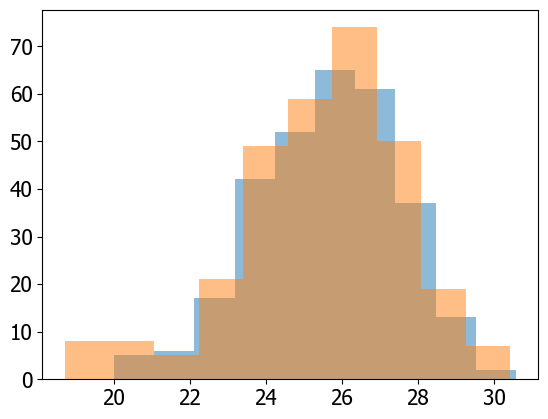

In [10]:
# Example comparison of the distributions from two bootstraps and the results of the KS and CvM tests for these bootstraps
plt.hist(boot_x, bins = 10, alpha = .5)
plt.hist(boot_y, bins = 10, alpha = .5)

print(ss.kstest(boot_x, boot_y))
print(ss.cramervonmises_2samp(boot_x, boot_y))

Text(0.5, 1.0, 'Permutation bootstrap distribution of p values')

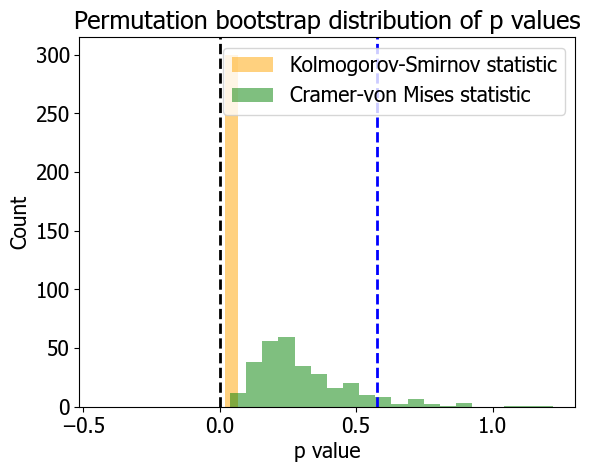

In [11]:
num_bins = 20
#plt.hist(np.round(ks_pvals, 6), bins = num_bins, alpha=.5, color = 'black', label = 'Kolmogorov-Smirnov p value') # round the pvalues to 5 sig figures
#plt.hist(np.round(cvm_pvals, 6), bins = num_bins, alpha=.5, color = 'blue', label = 'Cramer-von Mises p value')

plt.hist(np.round(ks_stats, 6), bins = num_bins, alpha=.5, color = 'orange', label = 'Kolmogorov-Smirnov statistic') # round the pvalues to 5 sig figures
plt.hist(np.round(cvm_stats, 6), bins = num_bins, alpha=.5, color = 'green', label = 'Cramer-von Mises statistic')
plt.legend()

# Establish confidence intervals for the data -- if the two distributions are the same then the p-value distribution should be flat, where 5% of the time the pvalue randomly is <.05
confidence_level = 0.95
upper_bound_quantile = ss.scoreatpercentile(ks_pvals, confidence_level * 100)
plt.axvline(upper_bound_quantile, color='black', linestyle='--', linewidth=2, label=f'Upper 95% CI: {upper_bound_quantile:.2f}')

upper_bound_quantile = ss.scoreatpercentile(cvm_pvals, confidence_level * 100)
plt.axvline(upper_bound_quantile, color='blue', linestyle='--', linewidth=2, label=f'Upper 95% CI: {upper_bound_quantile:.2f}')
plt.xlabel('p value')
plt.ylabel('Count')
plt.title('Permutation bootstrap distribution of p values')

In [8]:
x = combined_data['WT']
y = combined_data['P210S']
rng = random_state=np.random.default_rng()
len(x)
#res = ss.bootstrap((x, y), ks_pval, n_resamples=100, batch=100, paired=True, random_state=np.random.default_rng())
#print(res.confidence_interval)

300000

In [5]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]